# Analysis of WY2003 PF-CLM runs (for spinup)

In [1]:
import os
import sys
from datetime import datetime
from parflow.tools import Run
from parflow.tools.fs import mkdir, cp, get_absolute_path, exists
from parflow.tools.settings import set_working_directory
import numpy as np
import matplotlib.pyplot as plt
from parflow.tools.io import read_pfb,write_pfb, read_clm
import calendar

from parflow import Run
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import rasterio as rst 
import parflow.tools.hydrology as hydro
from parflow.tools.io import read_pfb,write_pfb, read_clm
import parflow.tools.hydrology as hydro
import random
import os
import calendar
import xarray as xr


In [22]:
"""
Creating the run object from the pdifb and getting grid size and shape. 
Then creating data accessor object ("data = ...")
"""
runname = 'East_taylor_newbounds_5.wy2003' # change runname for analysis of each WY2003 simulation of spinup
path_run = f'/hydrodata/temp/EastTaylor_ashley/{runname}/'

run = Run.from_definition(f'{path_run}{runname}.pfidb')
run.Solver.CLM.MetFilePath = '~/EastTaylor_inputs/newbounds_CW3E_WY2003' # forcing

data = run.data_accessor # creating data accessor object 
dx = data.dx
dy = data.dy
dz = data.dz
na,ny,nx = data.shape

porosity= data.computed_porosity
specific_storage = data.specific_storage
mask = data.mask
mask[mask>0]=1 # PF has big # instead of 1 so change to 1 bc more manageable
surf_mask = mask[-1,:,:] # last element of first axis (always be surface no matter what)


# Mannings not always printed as outputm so it's a special case
if run.Mannings.Type == 'PFBFile':
    mannings = np.squeeze(read_pfb(f'{path_run}{run.Mannings.FileName}'))
elif run.Mannings.Type == 'Constant':
    mannings = run.Mannings.Geom.domain.Value
slopex = np.squeeze(data.slope_x)
slopey = np.squeeze(data.slope_y)

# for converting from LE to ET
rho_w = 1000 # kg/m3
h_vap   = 2.5104e06

print(dx, dy)

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


1000 1000


In [5]:
# """
# Reading CLM Outputs:
# """
# eflx_lh_tot = data.clm_output('eflx_lh_tot') # latent heat flux total [W/m2] using silo variable LatentHeat - ACTUALLY USE THIS AND CONVERT TO PLOT TOTAL ET (next line)
# #e_mm_s = eflx_lh_tot*(1/rho_w)*(1/h_vap)*1000

# eflx_lwrad_out  = data.clm_output('eflx_lwrad_out') #  outgoing long-wave radiation [W=m2] using the silo variable LongWave;
# eflx_sh_tot  = data.clm_output('eflx_sh_tot') #  sensible heat flux total [W/m2] using the silo variable SensibleHeat;
# eflx_soil_grnd  = data.clm_output('eflx_soil_grnd') #  ground heat flux [W/m2] using the silo variable GroundHeat;
# qflx_evap_tot  = data.clm_output('qflx_evap_tot') #  total evaporation [mm/s] using the silo variable EvaporationTotal;
# qflx_evap_grnd  = data.clm_output('qflx_evap_grnd') #  ground evaporation without condensation [mm=s] using the silo variable EvaporationGround-NoSublimation;
# qflx_evap_soi  = data.clm_output('qflx_evap_soi') #  soil evaporation [mm/s] using the silo variable EvaporationGround;
# qflx_evap_veg  = data.clm_output('qflx_evap_veg') #  vegetation evaporation [mm/s] using the silo variable EvaporationCanopy;
#qflx_tran_veg  = data.clm_output('qflx_tran_veg') #  vegetation transpiration [mm/s] using the silo variable Transpiration;
# qflx_infl  = data.clm_output('qflx_infl') #  soil infiltration [mm/s] using the silo variable Infiltration;
# swe_out  = data.clm_output('swe_out') #  snow water equivalent [mm] using the silo variable SWE;
# t_grnd  = data.clm_output('t_grnd') #  ground surface temperature [K] using the silo variable TemperatureGround; and
# t_soil  = data.clm_output('t_soil') #  soil temperature over all layers [K] using the silo variable TemperatureSoil.
# qflx_evap_tot.shape


## Checking storage change with each run

In [23]:
"""
getting storage and fluxes

only run once to save out arrays, load in the next cell
"""

year = 2003
if calendar.isleap(year) == False:

    num_tsteps = 8760+1
else: 
    num_tsteps = 8784+1
# tstep_range = np.arange(0,8760,24)
# num_tsteps = len(tstep_range)

surface_storage = np.zeros(num_tsteps)
subsurface_storage = np.zeros(num_tsteps)
et_sum = np.zeros(num_tsteps)
precip = np.zeros(num_tsteps)
overland_out = np.zeros(num_tsteps)
swe = np.zeros(num_tsteps)


# for t in range(num_tsteps):
for t in range(0,num_tsteps):
    
    # tstep_range[-1]
    data.time = t
    pressure = data.pressure 
    saturation = data.saturation

    subsurface_storage[t] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx,dy,dz, mask=mask),axis=(0,1,2))
    surface_storage[t] = np.sum(hydro.calculate_surface_storage(pressure, dx, dy, mask=mask), axis=(0,1))
    overland_out[t] = hydro.calculate_overland_flow(pressure, slopex, slopey, mannings, dx, dy, flow_method=run.Patch.top.BCPressure.Type,mask=mask)


                                
    if t > 0: 
        data.forcing_time = t-1
        precip[t] = np.sum(data.clm_forcing('APCP')[surf_mask==1])#*(3600/1000)*(dx)*(dy) # get rid of unit conversions
        et_sum[t]  = np.sum(data.clm_output('eflx_lh_tot')[surf_mask==1])*(1/rho_w)*(1/h_vap)#*(3600/1000)*(dx)*(dy)
        swe[t]  = np.sum(data.clm_output('swe_out')[surf_mask==1])#*(1/1000)*(dx)*(dy)
    

np.save("subsurface_wy2003_5", subsurface_storage)
np.save("surface_wy2003_5", surface_storage)
np.save("overland_out_wy2003_5",  overland_out)

np.save("precip_wy2003_5", precip)
np.save("et_wy2003_5", et_sum)
np.save("swe_wy2003_5", swe)


In [17]:
# load in arrays from prev cell - not the same units
# number corresponds to which 2017 run
subsurface_storage_1 = np.load("subsurface_wy2003_1.npy") # m3
surface_storage_1 = np.load("surface_wy2003_1.npy") # m3

precip_1 = np.load("precip_wy2003_1.npy") # mm/hr, multiply by 3600 seconds in 1 hour, 1000mm in 1m, dx dy
et_1 = np.load("et_wy2003_1.npy") # m/s, multiply by dx dy
swe_1 = np.load("swe_wy2003_1.npy") # mm, multiply by 1000m in 1m, dx dy


subsurface_storage_2 = np.load("subsurface_wy2003_2.npy") # m3
surface_storage_2 = np.load("surface_wy2003_2.npy") # m3

precip_2 = np.load("precip_wy2003_2.npy") # mm/hr, multiply by 3600 seconds in 1 hour, 1000mm in 1m, dx dy
et_2 = np.load("et_wy2003_2.npy") # m/s, multiply by dx dy
swe_2 = np.load("swe_wy2003_2.npy") # mm, multiply by 1000m in 1m, dx dy


subsurface_storage_3 = np.load("subsurface_wy2003_3.npy") # m3
surface_storage_3 = np.load("surface_wy2003_3.npy") # m3

precip_3 = np.load("precip_wy2003_3.npy") # mm/hr, multiply by 3600 seconds in 1 hour, 1000mm in 1m, dx dy
et_3 = np.load("et_wy2003_3.npy") # m/s, multiply by dx dy
swe_3 = np.load("swe_wy2003_3.npy") # mm, multiply by 1000m in 1m, dx dy


subsurface_storage_4 = np.load("subsurface_wy2003_4.npy") # m3
surface_storage_4 = np.load("surface_wy2003_4.npy") # m3

precip_4 = np.load("precip_wy2003_4.npy") # mm/hr, multiply by 3600 seconds in 1 hour, 1000mm in 1m, dx dy
et_4 = np.load("et_wy2003_4.npy") # m/s, multiply by dx dy
swe_4 = np.load("swe_wy2003_4.npy") # mm, multiply by 1000m in 1m, dx dy


subsurface_storage_5 = np.load("subsurface_wy2003_5.npy") # m3
surface_storage_5 = np.load("surface_wy2003_5.npy") # m3

precip_5 = np.load("precip_wy2003_5.npy") # mm/hr, multiply by 3600 seconds in 1 hour, 1000mm in 1m, dx dy
et_5 = np.load("et_wy2003_5.npy") # m/s, multiply by dx dy
swe_5 = np.load("swe_wy2003_5.npy") # mm, multiply by 1000m in 1m, dx dy



In [18]:
# converting so everything is in m3
precip_m3_hr_1 = precip_1*(3600/1000)*(dx)*(dy)
et_m3_hr_1 = et_1*3600*dx*dy
swe_m3_1 = swe_1*(1/1000)*dx*dy

precip_m3_hr_2 = precip_2*(3600/1000)*(dx)*(dy)
et_m3_hr_2 = et_2*3600*dx*dy
swe_m3_2 = swe_2*(1/1000)*dx*dy

precip_m3_hr_3 = precip_3*(3600/1000)*(dx)*(dy)
et_m3_hr_3 = et_3*3600*dx*dy
swe_m3_3 = swe_3*(1/1000)*dx*dy

precip_m3_hr_4 = precip_4*(3600/1000)*(dx)*(dy)
et_m3_hr_4 = et_4*3600*dx*dy
swe_m3_4 = swe_4*(1/1000)*dx*dy

precip_m3_hr_5 = precip_5*(3600/1000)*(dx)*(dy)
et_m3_hr_5 = et_5*3600*dx*dy
swe_m3_5 = swe_5*(1/1000)*dx*dy


In [19]:
# change in storage btwn start and end of each run
storage_change_1 = (subsurface_storage_1[-1] + surface_storage_1[-1]) - (subsurface_storage_1[0] + surface_storage_1[0])
print("change in storage, WY2003 run 1 = ", storage_change_1)

# precip - et
pme_1 = np.sum(precip_m3_hr_1) - np.sum(et_m3_hr_1)
print("precip - et, WY2003 run 1 = ", storage_change_1)

#normalized storage change
norm_storage_change_1 = storage_change_1 / pme_1
print("normalized change in storage, WY2003 run 1 = ", norm_storage_change_1)


# print('')

storage_change_2 = (subsurface_storage_2[-1] + surface_storage_2[-1]) - (subsurface_storage_2[0] + surface_storage_2[0])
print("change in storage, WY2003 run 2 = ", storage_change_2)

# precip - et
pme_2 = np.sum(precip_m3_hr_2) - np.sum(et_m3_hr_2)
print("precip - et, WY2003 run 2 = ", storage_change_2)

#normalized storage change
norm_storage_change_2 = storage_change_2 / pme_2
print("normalized change in storage, WY2003 run 1 = ", norm_storage_change_2)


print('')

storage_change_3 = (subsurface_storage_3[-1] + surface_storage_3[-1]) - (subsurface_storage_3[0] + surface_storage_3[0])
print("change in storage, WY2017 run 3 = ", storage_change_3)

# precip - et
pme_3 = np.sum(precip_m3_hr_3) - np.sum(et_m3_hr_3)
print("precip - et, WY2017 run 3 = ", storage_change_3)

#normalized storage change
norm_storage_change_3 = storage_change_3 / pme_3
print("normalized change in storage, WY2017 run 3 = ", norm_storage_change_3)

print('')

storage_change_4 = (subsurface_storage_4[-1] + surface_storage_4[-1]) - (subsurface_storage_4[0] + surface_storage_4[0])
print("change in storage, WY2017 run 4 = ", storage_change_4)

# precip - et
pme_4 = np.sum(precip_m3_hr_4) - np.sum(et_m3_hr_4)
print("precip - et, WY2017 run 4 = ", storage_change_4)

#normalized storage change
norm_storage_change_4 = storage_change_4 / pme_4
print("normalized change in storage, WY2017 run 4 = ", norm_storage_change_4)

print('')

storage_change_5 = (subsurface_storage_5[-1] + surface_storage_5[-1]) - (subsurface_storage_5[0] + surface_storage_5[0])
print("change in storage, WY2017 run 5 = ", storage_change_5)

# precip - et
pme_5 = np.sum(precip_m3_hr_5) - np.sum(et_m3_hr_5)
print("precip - et, WY2017 run 5 = ", storage_change_5)

#normalized storage change
norm_storage_change_5 = storage_change_5 / pme_5
print("normalized change in storage, WY2017 run 5 = ", norm_storage_change_5)



change in storage, WY2003 run 1 =  13824589.154342651
precip - et, WY2003 run 1 =  13824589.154342651
normalized change in storage, WY2003 run 1 =  0.03734912805593508
change in storage, WY2003 run 2 =  43453877.361076355
precip - et, WY2003 run 2 =  43453877.361076355
normalized change in storage, WY2003 run 1 =  0.09969426954889168

change in storage, WY2017 run 3 =  21942750.95425415
precip - et, WY2017 run 3 =  21942750.95425415
normalized change in storage, WY2017 run 3 =  0.04941367685997077

change in storage, WY2017 run 4 =  13356582.76789856
precip - et, WY2017 run 4 =  13356582.76789856
normalized change in storage, WY2017 run 4 =  0.030052043429053314

change in storage, WY2017 run 5 =  8924365.264015198
precip - et, WY2017 run 5 =  8924365.264015198
normalized change in storage, WY2017 run 5 =  0.02011712791403498


Text(0.5, 1.0, 'Spin-up Progress, WY2003')

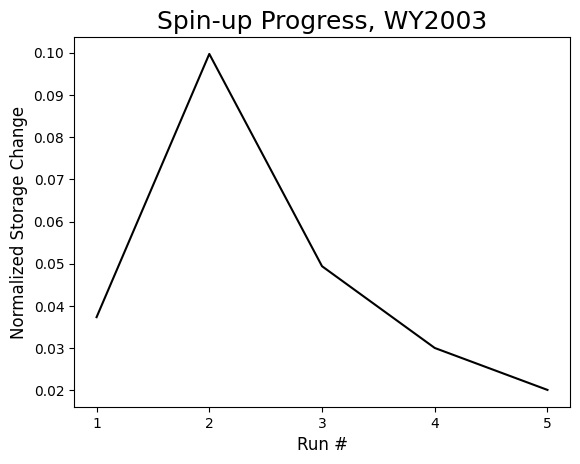

In [20]:
runs = np.array([1,2,3,4,5])

storage = np.array([norm_storage_change_1, norm_storage_change_2, norm_storage_change_3, norm_storage_change_4, norm_storage_change_5])

plt.plot(runs, storage, c = 'black')
plt.xlabel('Run #', fontsize = 12)
plt.ylabel('Normalized Storage Change', fontsize = 12)
plt.xticks([1, 2, 3, 4,5])
plt.title('Spin-up Progress, WY2003', fontsize = 18)

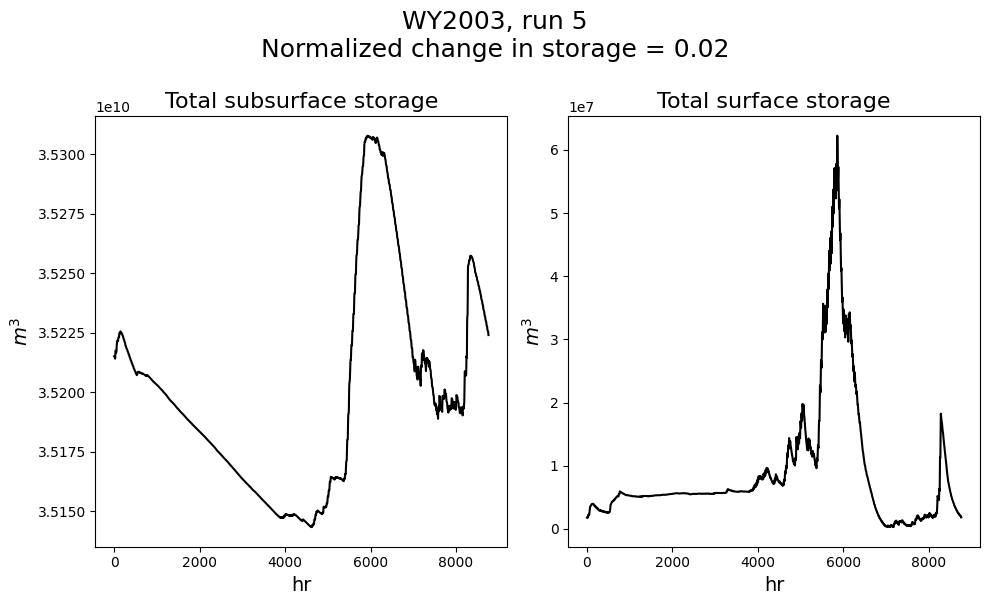

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle(f"WY2003, run 5\nNormalized change in storage = {np.round(norm_storage_change_5, 3)}", y = 1.0, fontsize = 18)
axs[0].plot(subsurface_storage_5, c = 'black')
axs[0].set_title("Total subsurface storage", fontsize = 16)
axs[0].set_ylabel("$m^3$", fontsize = 14)
axs[0].set_xlabel("hr", fontsize = 14)
#axs[0].text(0,0, ("storage change, normalized by P - ET = ", norm_storage_change_4))

axs[1].plot(surface_storage_5, c = 'black')
axs[1].set_title("Total surface storage", fontsize = 16)
axs[1].set_ylabel("$m^3$", fontsize = 14)
axs[1].set_xlabel("hr", fontsize = 14)

plt.tight_layout()
